In [48]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class SVM(object):
    def __init__(self, C=1.0):
        self._support_vectors = None    # 支持向量机索引
        self.C = C   # 惩罚函数
        self.W = None   # 分类超平面的法向量
        self.b = None   # 分类超平面的偏置
        self.x = None   # 训练数据
        self.y = None   # 训练标签
        self.n = 0  # 样本数量
        self.d = 0  # 特征数量

    def __desicion_function(self, X):
        return X.dot(self.W)+self.b     # 判断样本点相对于超平面的位置

    def __margin(self, X, y):
        return y*self.__desicion_function(X)  #  得到约束条件

    def __cost(self, margin):
        return (1/2)*self.W.dot(self.W)+self.C*np.sum(np.maximum(0,1-margin)) # 损失函数
        # 松弛变量用hinge损失表示


    def fit(self,X,y,lr=1e-3,epochs=500):
        self.n,self.d=X.shape[0],X.shape[1] # n为样本数量 , d为特征数量,分别为数据的行大小与列大小
        self.W=np.random.rand(self.d)   # 随机初始化权重向量
        self.b=np.random.rand() # 随机化偏置

        self.x=X
        self.y=y
        losses=[]   # 用于保存每轮迭代的损失值

        for i in range(epochs):
            margin=self.__margin(X,y)   # 求出这一轮的数据间隔
            loss=self.__cost(margin)    # 根据间隔值算出损失值
            losses.append(loss) # 将这一轮损失值添加到losses数组中

            missclassified_pts_idx=np.where(margin<1)[0]    #找到被分类错误的样本点
            d_W=self.W-self.C*y[missclassified_pts_idx].dot(X[missclassified_pts_idx]) #权重梯度计算
            self.W=self.W-lr*d_W #更新权重

            # d_gama=-self.C*np.sum(y[missclassified_pts_idx])
            # self.b=self.d_gama-lr*d_gama

            self._support_vectors=np.where(self.__margin(X,y)<1)[0] # 更新支持向量索引

    def predict(self, X):
        return np.sign(self.__desicion_function(X))

    def score(self, X, y):
        P = self.predict(X)
        return np.mean(P==y)

    def plotresult(self):
        plt.figure()
        plt.scatter(self.x[:,0], self.x[:, 1], c= self.y, s = 50, cmap=plt.cm.Paired, alpha=0.7)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        XX, YY = np.meshgrid(xx, yy)
        xy = np.stack([XX.ravel(), YY.ravel()], axis=1)
        z = self.__desicion_function(xy).reshape(XX.shape)
        ax.contour(XX,YY,z,colors = ['r', 'b','r'], levels = [-1,0,1],alpha = 0.5, linestyles=['--','-','--'],linewidths=[2.0,2.0,2.0])

        ax.scatter(self.x[:,0][self._support_vectors],self.x[:,1][self._support_vectors],s=100,linewidth=1,facecolors='r',edgecolors='r')

        plt.show()

TrainScore: 0.5


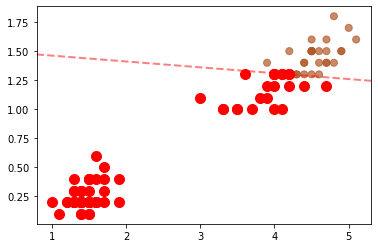

In [50]:
if __name__ == '__main__':
    iris = datasets.load_iris()
    X_train, y_target = iris.data[:100, [2, 3]], iris.target[:100]
    y_target[y_target == 0] = -1

    model=SVM(C=0.10)
    model.fit(X_train,y_target)
    print(f'TrainScore: {model.score(X_train,y_target)}')
    model.plotresult()


In [51]:
import pandas as pd

In [52]:
iris = pd.DataFrame(iris.data)

In [53]:
iris.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [66]:
class SVM(object):
    def __init__(self, C=1.0, kernel='linear', gamma=1.0):
        # 初始化SVM类
        self._support_vectors = None
        self.C = C  # 惩罚函数参数
        self.W = None  # 分类超平面的法向量
        self.b = None  # 分类超平面的偏置
        self.x = None  # 训练数据
        self.y = None  # 训练标签
        self.n = 0  # 样本数量
        self.d = 0  # 特征数量
        self.kernel = kernel  # 核函数类型
        self.gamma = gamma    # RBF核函数参数

    def __kernel_function(self,X1, X2):
        # x1:支持向量 X2: 输入参数
        # 计算核函数的值
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            diff = X1[:, np.newaxis] - X2
            norm_sq = np.linalg.norm(diff, axis=2)**2
            return np.exp(-self.gamma * norm_sq)

    def __decision_function(self, X):
        # 计算决策函数的输出
        # return np.dot(self.W, self.__kernel_function(self.x, X)) + self.b
        decision_values = []
        for i in range(self.n):
            kernel_values = self.__kernel_function(self.x[self._support_vectors], X[i, :])
            decision_value = np.sum(self.W[self._support_vectors] * kernel_values) + self.b
            decision_values.append(decision_value)
        return np.array(decision_values)

    def __margin(self, X, y):
        # 计算约束条件
        return y * self.__decision_function(X)

    def __cost(self, margin):
        # 计算损失函数
        return (1/2) * self.W.dot(self.W) + self.C * np.sum(np.maximum(0, 1 - margin))

    def fit(self, X, y, lr=1e-3, epochs=500):
        # 获取样本数量和特征数量
        self.n, self.d = X.shape[0], X.shape[1]
        # 随机初始化权重向量
        self.W = np.random.rand(self.d)
        # 随机初始化偏置
        self.b = np.random.rand()
        # 保存训练数据和标签
        self.x = X
        self.y = y
        losses = []  # 保存每轮迭代的损失值

        for i in range(epochs):
            margin = self.__margin(X, y)   # 计算数据点与超平面的间隔
            loss = self.__cost(margin)     # 根据间隔计算损失
            losses.append(loss)  # 将本轮损失添加到losses数组

            missclassified_pts_idx = np.where(margin < 1)[0]  # 找到被错误分类的样本点
            support_vectors_x = self.x[self._support_vectors]
            d_W = self.W - self.C * y[missclassified_pts_idx].dot(self.__kernel_function(support_vectors_x, X[missclassified_pts_idx]))
            self.W = self.W - lr * d_W  # 更新权重

            self._support_vectors = np.where(self.__margin(X, y) < 1)[0]  # 更新支持向量索引

    def predict(self, X):
        # 预测新数据点的类别
        return np.sign(self.__decision_function(X))

    def score(self, X, y):
        # 计算模型在数据集上的准确率
        P = self.predict(X)
        return np.mean(P == y)

    def plotresult(self):
        # 绘制分类结果
        plt.figure()
        plt.scatter(self.x[:, 0], self.x[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=0.7)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        XX, YY = np.meshgrid(xx, yy)
        xy = np.stack([XX.ravel(), YY.ravel()], axis=1)
        z = self.__decision_function(xy).reshape(XX.shape)
        ax.contour(XX, YY, z, colors=['r', 'b', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        ax.scatter(self.x[:, 0][self._support_vectors], self.x[:, 1][self._support_vectors], s=100, linewidth=1, facecolors='r', edgecolors='r')

        plt.show()


In [67]:
if __name__ == "__main__":
    np.random.seed(42)
    X = np.random.randn(100, 2)
    y = np.where(X[:, 0] + X[:, 1] > 0, 1, -1)

    svm = SVM(C=1.0, kernel='rbf', gamma=0.5)
    svm.fit(X, y)
    svm.plotresult()

ValueError: shapes (100,) and (1,1,2) not aligned: 100 (dim 0) != 1 (dim 1)

In [ ]:
sklearn.svm